In [1]:
import pandas as np
df = np.read_csv('mbti_1.csv')

# populating types array
labels = []
for _type in df['type']:
     labels.append(_type)

In [2]:
import pickle

posts = []
with open ('processed_posts.pkl', 'rb') as fp:
    posts = pickle.load(fp)

In [3]:
tokenized_posts = []

for post in posts:
    user = []
    for sentence in post:
        user += sentence.split(" ")
        
    tokenized_posts.append(user)

In [4]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [5]:
from collections import Counter

In [6]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [7]:
dictionary = list(zip(*dictionary))[0]

In [8]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [9]:
x_vals = []
for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [10]:
def to_one_hot(arr):
    
    one_hot_array = []
    type_dictionary = {
            "T": 0,
            "F": 1
        }
    
    for label in arr:
        one_hot_array.append(type_dictionary[label[2]])
        
    return one_hot_array

In [11]:
import numpy as np
from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x = vectorize_sequences(x_vals)
y = np.asarray(to_one_hot(labels)).astype('float32')

Using TensorFlow backend.


In [12]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [13]:
x_test = x[:1000]
y_test = y[:1000]

x_train = x[1000:]
y_train = y[1000:]

x_val = x_train[:500]
y_val = y_train[:500]

partial_x_train = x_train[500:]
partial_y_train = y_train[500:]

In [14]:
#These are for full label prediction
#class_weights = [{0:1, 1:8}, {0:1, 1:6.24}, {0:1, 1:1.18}, {0:1, 1:0.65}]
class_weights = {0:1, 1:1.18}

In [22]:
# FEED FORWARD MODEL
from keras import models
from keras import layers
from keras.regularizers import l2
import tensorflow as tf
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape = (10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    return model

In [25]:
from keras.callbacks import Callback

class True_eval(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.total_accuracy = []
        self.i_accuracy = []
        self.e_accuracy = []
    
    def ie_real_acc(self, prediction):
        y_true = self.validation_data[1]
        i_acc = 0
        i_total = 0
        e_acc = 0
        e_total = 0
        for i in range(0, len(prediction)):
            if (y_true[i].round() == 0):
                if (prediction[i].round() == y_true[i]):
                    i_acc += 1
                i_total += 1
            else:
                if (prediction[i].round() == y_true[i]):
                    e_acc += 1
                e_total += 1
        return (i_acc/i_total), (e_acc/e_total)

    def on_epoch_end(self, epoch, logs={}):
        x_val = self.validation_data[0]
        y_pred = self.model.predict(x_val)
        i_real_acc, e_real_acc = self.ie_real_acc(y_pred)
        print ("T Acc: %f" % i_real_acc)
        print ("F Acc: %f" % e_real_acc)
        self.i_accuracy.append(i_real_acc)
        self.e_accuracy.append(e_real_acc)

In [37]:
model = build_model()
with tf.device('/gpu:0'):
    true_metrics = True_eval((x_val, y_val))
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data= (x_val, y_val),
                        epochs = 400, batch_size = 512,
                        class_weight=class_weights,
                        callbacks=[true_metrics])

Train on 7175 samples, validate on 500 samples
Epoch 1/400
7175/7175 [==============================] - 1s 170us/step - loss: 0.7174 - acc: 0.5773 - val_loss: 0.6138 - val_acc: 0.7680
T Acc: 0.739130
F Acc: 0.792593
Epoch 2/400
7175/7175 [==============================] - 1s 91us/step - loss: 0.6072 - acc: 0.7228 - val_loss: 0.6136 - val_acc: 0.6100
T Acc: 0.165217
F Acc: 0.988889
Epoch 3/400
7175/7175 [==============================] - 1s 108us/step - loss: 0.5357 - acc: 0.7801 - val_loss: 0.5427 - val_acc: 0.6960
T Acc: 0.391304
F Acc: 0.955556
Epoch 4/400
7175/7175 [==============================] - 1s 94us/step - loss: 0.4802 - acc: 0.8020 - val_loss: 0.5428 - val_acc: 0.7220
T Acc: 0.960870
F Acc: 0.518519
Epoch 5/400
7175/7175 [==============================] - 1s 88us/step - loss: 0.4268 - acc: 0.8325 - val_loss: 0.4492 - val_acc: 0.7900
T Acc: 0.678261
F Acc: 0.885185
Epoch 6/400
7175/7175 [==============================] - 1s 88us/step - loss: 0.3866 - acc: 0.8538 - val_loss: 

7175/7175 [==============================] - 1s 86us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.9192 - val_acc: 0.7820
T Acc: 0.760870
F Acc: 0.800000
Epoch 50/400
7175/7175 [==============================] - 1s 86us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 1.0100 - val_acc: 0.7820
T Acc: 0.700000
F Acc: 0.851852
Epoch 51/400
7175/7175 [==============================] - 1s 87us/step - loss: 0.0764 - acc: 0.9706 - val_loss: 0.9161 - val_acc: 0.7900
T Acc: 0.804348
F Acc: 0.777778
Epoch 52/400
7175/7175 [==============================] - 1s 85us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.9306 - val_acc: 0.7840
T Acc: 0.773913
F Acc: 0.792593
Epoch 53/400
7175/7175 [==============================] - 1s 87us/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.9607 - val_acc: 0.7860
T Acc: 0.795652
F Acc: 0.777778
Epoch 54/400
7175/7175 [==============================] - 1s 87us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 1.0054 - val_acc: 0.7900
T Acc: 0.821739
F Acc: 0.762963

7175/7175 [==============================] - 1s 87us/step - loss: 0.0462 - acc: 0.9838 - val_loss: 1.5629 - val_acc: 0.7800
T Acc: 0.821739
F Acc: 0.744444
Epoch 98/400
7175/7175 [==============================] - 1s 86us/step - loss: 2.1449e-04 - acc: 1.0000 - val_loss: 1.5522 - val_acc: 0.7840
T Acc: 0.808696
F Acc: 0.762963
Epoch 99/400
7175/7175 [==============================] - 1s 86us/step - loss: 2.0388e-04 - acc: 1.0000 - val_loss: 1.5485 - val_acc: 0.7780
T Acc: 0.791304
F Acc: 0.766667
Epoch 100/400
7175/7175 [==============================] - 1s 88us/step - loss: 1.9612e-04 - acc: 1.0000 - val_loss: 1.5463 - val_acc: 0.7740
T Acc: 0.773913
F Acc: 0.774074
Epoch 101/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.9015e-04 - acc: 1.0000 - val_loss: 1.5505 - val_acc: 0.7740
T Acc: 0.769565
F Acc: 0.777778
Epoch 102/400
7175/7175 [==============================] - 1s 87us/step - loss: 1.8554e-04 - acc: 1.0000 - val_loss: 1.5589 - val_acc: 0.7760
T Acc: 0

7175/7175 [==============================] - 1s 87us/step - loss: 2.9480e-05 - acc: 1.0000 - val_loss: 2.0101 - val_acc: 0.7780
T Acc: 0.813043
F Acc: 0.748148
Epoch 145/400
7175/7175 [==============================] - 1s 86us/step - loss: 2.6034e-05 - acc: 1.0000 - val_loss: 1.9969 - val_acc: 0.7800
T Acc: 0.808696
F Acc: 0.755556
Epoch 146/400
7175/7175 [==============================] - 1s 87us/step - loss: 2.4935e-05 - acc: 1.0000 - val_loss: 1.9858 - val_acc: 0.7820
T Acc: 0.804348
F Acc: 0.762963
Epoch 147/400
7175/7175 [==============================] - 1s 87us/step - loss: 2.3752e-05 - acc: 1.0000 - val_loss: 1.9762 - val_acc: 0.7760
T Acc: 0.782609
F Acc: 0.770370
Epoch 148/400
7175/7175 [==============================] - 1s 85us/step - loss: 2.2499e-05 - acc: 1.0000 - val_loss: 1.9740 - val_acc: 0.7820
T Acc: 0.773913
F Acc: 0.788889
Epoch 149/400
7175/7175 [==============================] - 1s 87us/step - loss: 2.1055e-05 - acc: 1.0000 - val_loss: 1.9794 - val_acc: 0.7840
T 

7175/7175 [==============================] - 1s 86us/step - loss: 1.4518e-07 - acc: 1.0000 - val_loss: 2.4158 - val_acc: 0.7840
T Acc: 0.769565
F Acc: 0.796296
Epoch 192/400
7175/7175 [==============================] - 1s 85us/step - loss: 1.4293e-07 - acc: 1.0000 - val_loss: 2.4184 - val_acc: 0.7840
T Acc: 0.769565
F Acc: 0.796296
Epoch 193/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.4098e-07 - acc: 1.0000 - val_loss: 2.4208 - val_acc: 0.7840
T Acc: 0.769565
F Acc: 0.796296
Epoch 194/400
7175/7175 [==============================] - 1s 85us/step - loss: 1.3936e-07 - acc: 1.0000 - val_loss: 2.4234 - val_acc: 0.7840
T Acc: 0.769565
F Acc: 0.796296
Epoch 195/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.3804e-07 - acc: 1.0000 - val_loss: 2.4248 - val_acc: 0.7820
T Acc: 0.769565
F Acc: 0.792593
Epoch 196/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.3683e-07 - acc: 1.0000 - val_loss: 2.4273 - val_acc: 0.7820
T 

7175/7175 [==============================] - 1s 86us/step - loss: 1.2463e-07 - acc: 1.0000 - val_loss: 2.4681 - val_acc: 0.7820
T Acc: 0.778261
F Acc: 0.785185
Epoch 239/400
7175/7175 [==============================] - 1s 87us/step - loss: 1.2457e-07 - acc: 1.0000 - val_loss: 2.4686 - val_acc: 0.7820
T Acc: 0.778261
F Acc: 0.785185
Epoch 240/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.2453e-07 - acc: 1.0000 - val_loss: 2.4690 - val_acc: 0.7820
T Acc: 0.778261
F Acc: 0.785185
Epoch 241/400
7175/7175 [==============================] - 1s 85us/step - loss: 1.2445e-07 - acc: 1.0000 - val_loss: 2.4694 - val_acc: 0.7820
T Acc: 0.778261
F Acc: 0.785185
Epoch 242/400
7175/7175 [==============================] - 1s 88us/step - loss: 1.2442e-07 - acc: 1.0000 - val_loss: 2.4699 - val_acc: 0.7820
T Acc: 0.778261
F Acc: 0.785185
Epoch 243/400
7175/7175 [==============================] - 1s 85us/step - loss: 1.2437e-07 - acc: 1.0000 - val_loss: 2.4702 - val_acc: 0.7820
T 

7175/7175 [==============================] - 1s 87us/step - loss: 1.2320e-07 - acc: 1.0000 - val_loss: 2.4853 - val_acc: 0.7780
T Acc: 0.782609
F Acc: 0.774074
Epoch 286/400
7175/7175 [==============================] - 1s 88us/step - loss: 1.2320e-07 - acc: 1.0000 - val_loss: 2.4856 - val_acc: 0.7780
T Acc: 0.782609
F Acc: 0.774074
Epoch 287/400
7175/7175 [==============================] - 1s 85us/step - loss: 1.2319e-07 - acc: 1.0000 - val_loss: 2.4859 - val_acc: 0.7780
T Acc: 0.782609
F Acc: 0.774074
Epoch 288/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.2319e-07 - acc: 1.0000 - val_loss: 2.4862 - val_acc: 0.7780
T Acc: 0.782609
F Acc: 0.774074
Epoch 289/400
7175/7175 [==============================] - 1s 87us/step - loss: 1.2317e-07 - acc: 1.0000 - val_loss: 2.4865 - val_acc: 0.7780
T Acc: 0.782609
F Acc: 0.774074
Epoch 290/400
7175/7175 [==============================] - 1s 85us/step - loss: 1.2312e-07 - acc: 1.0000 - val_loss: 2.4868 - val_acc: 0.7780
T 

7175/7175 [==============================] - 1s 86us/step - loss: 1.2277e-07 - acc: 1.0000 - val_loss: 2.4977 - val_acc: 0.7760
T Acc: 0.782609
F Acc: 0.770370
Epoch 333/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.2277e-07 - acc: 1.0000 - val_loss: 2.4979 - val_acc: 0.7760
T Acc: 0.782609
F Acc: 0.770370
Epoch 334/400
7175/7175 [==============================] - 1s 85us/step - loss: 1.2273e-07 - acc: 1.0000 - val_loss: 2.4981 - val_acc: 0.7760
T Acc: 0.782609
F Acc: 0.770370
Epoch 335/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.2271e-07 - acc: 1.0000 - val_loss: 2.4982 - val_acc: 0.7760
T Acc: 0.782609
F Acc: 0.770370
Epoch 336/400
7175/7175 [==============================] - 1s 85us/step - loss: 1.2271e-07 - acc: 1.0000 - val_loss: 2.4984 - val_acc: 0.7760
T Acc: 0.782609
F Acc: 0.770370
Epoch 337/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.2270e-07 - acc: 1.0000 - val_loss: 2.4986 - val_acc: 0.7760
T 

7175/7175 [==============================] - 1s 89us/step - loss: 1.2252e-07 - acc: 1.0000 - val_loss: 2.5061 - val_acc: 0.7780
T Acc: 0.786957
F Acc: 0.770370
Epoch 380/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.2252e-07 - acc: 1.0000 - val_loss: 2.5063 - val_acc: 0.7780
T Acc: 0.786957
F Acc: 0.770370
Epoch 381/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.2252e-07 - acc: 1.0000 - val_loss: 2.5064 - val_acc: 0.7780
T Acc: 0.786957
F Acc: 0.770370
Epoch 382/400
7175/7175 [==============================] - 1s 88us/step - loss: 1.2252e-07 - acc: 1.0000 - val_loss: 2.5066 - val_acc: 0.7780
T Acc: 0.786957
F Acc: 0.770370
Epoch 383/400
7175/7175 [==============================] - 1s 86us/step - loss: 1.2252e-07 - acc: 1.0000 - val_loss: 2.5067 - val_acc: 0.7780
T Acc: 0.786957
F Acc: 0.770370
Epoch 384/400
7175/7175 [==============================] - 1s 85us/step - loss: 1.2252e-07 - acc: 1.0000 - val_loss: 2.5069 - val_acc: 0.7780
T 

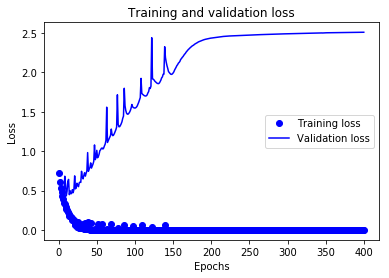

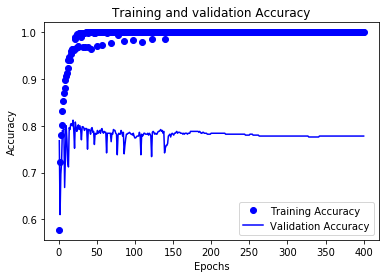

<Figure size 432x288 with 0 Axes>

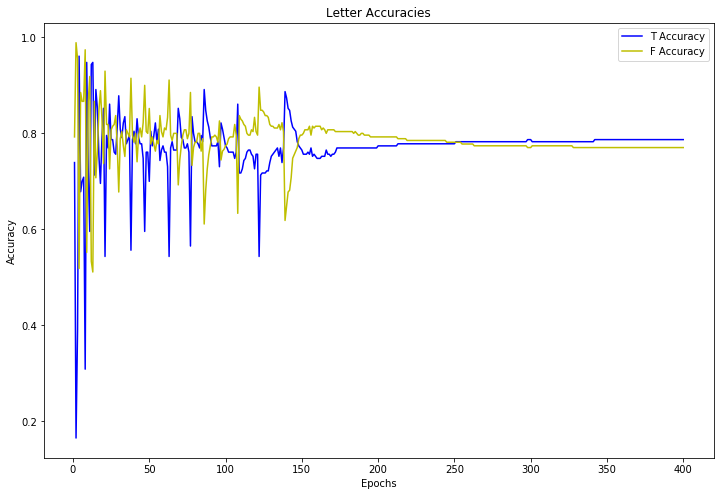

In [38]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.clf()

plt.figure(figsize=(12,8))
plt.plot(epochs, true_metrics.i_accuracy, 'b', label='T Accuracy')
plt.plot(epochs, true_metrics.e_accuracy, 'y', label='F Accuracy')
plt.title('Letter Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
model = build_model()
with tf.device('/gpu:0'):
    model.fit(x_train, y_train, epochs = 50, batch_size = 512, class_weight=class_weights)
    y_pred = model.predict(x_test)
    results = model.evaluate(x_test, y_test)
results

Epoch 1/50
7675/7675 [==============================] - 1s 152us/step - loss: 0.7379 - acc: 0.5347
Epoch 2/50
7675/7675 [==============================] - 1s 83us/step - loss: 0.6720 - acc: 0.5866
Epoch 3/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.6287 - acc: 0.6748
Epoch 4/50
7675/7675 [==============================] - 1s 81us/step - loss: 0.5815 - acc: 0.7410
Epoch 5/50
7675/7675 [==============================] - 1s 85us/step - loss: 0.5127 - acc: 0.8044
Epoch 6/50
7675/7675 [==============================] - 1s 80us/step - loss: 0.4471 - acc: 0.8236
Epoch 7/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.3727 - acc: 0.8650
Epoch 8/50
7675/7675 [==============================] - 1s 82us/step - loss: 0.3509 - acc: 0.8782
Epoch 9/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.3199 - acc: 0.8946
Epoch 10/50
7675/7675 [==============================] - 1s 81us/step - loss: 0.2976 - acc: 0.8984
Epoch 11/50
7675/7

[0.9689026575088501, 0.749]

Normalized confusion matrix


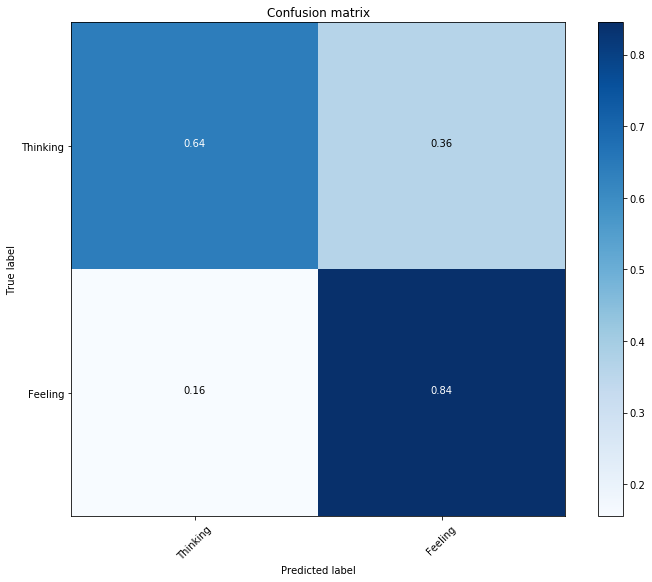

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import datetime

now = datetime.datetime.now()
pictures = []
folder = "FF"

def byte_to_mbti(byte):
    binary = ''
    for letter in byte:
         binary +=(str(int(letter)))        
    return type_dictionary[binary]

#decoded_y_true = [byte_to_mbti(label) for label in y_test.round()]
#decoded_y_pred = [byte_to_mbti(label) for label in y_pred.round()]

decoded_y_true = y_test.round()
decoded_y_pred = y_pred.round()

matrix = confusion_matrix(decoded_y_true, decoded_y_pred, labels=[0, 1])
#matrix_I_E = confusion_matrix(y_test[:,0], y_pred[:,0].round(), labels=[0, 1])
#matrix_N_S = confusion_matrix(y_test[:,1], y_pred[:,1].round(), labels=[0, 1])
#matrix_T_F = confusion_matrix(y_test[:,2], y_pred[:,2].round(), labels=[0, 1])
#matrix_J_P = confusion_matrix(y_test[:,3], y_pred[:,3].round(), labels=[0, 1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(10,8))
plot_confusion_matrix(matrix, classes=["Thinking","Feeling"], normalize=True,
                      title='Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM0.png"
plt.savefig(name)
plt.show()
pictures.append(name)

#plt.clf()
#plt.figure(figsize=(5,5))
#plot_confusion_matrix(matrix_I_E, classes=["I", "E"], normalize=True,
#                      title='I-E Confusion matrix')
#name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#str(now.hour) + "-" + str(now.minute) + "_" + "CM1.png"
#plt.savefig(name)
#plt.show()
#pictures.append(name)

#    plt.clf()
#    plt.figure(figsize=(5,5))
#    plot_confusion_matrix(matrix_N_S, classes=["N", "S"], normalize=True,
#                          title='N-S Confusion matrix')
#    name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#    str(now.hour) + "-" + str(now.minute) + "_" + "CM2.png"
#    plt.savefig(name)
#    plt.show()
#   pictures.append(name)

#    plt.clf()
#    plt.figure(figsize=(5,5))
#    plot_confusion_matrix(matrix_T_F, classes=["T", "F"], normalize=True,
#                          title='T-F Confusion matrix')
#    name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#    str(now.hour) + "-" + str(now.minute) + "_" + "CM3.png"
#    plt.savefig(name)
#    plt.show()
#    pictures.append(name)

#    plt.clf()
#    plt.figure(figsize=(5,5))
#    plot_confusion_matrix(matrix_J_P, classes=["J", "P"], normalize=True,
#                          title='J-P Confusion matrix')
#    name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#    str(now.hour) + "-" + str(now.minute) + "_" + "CM4.png"
#    plt.savefig(name)
#    plt.show()
#    pictures.append(name)